## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


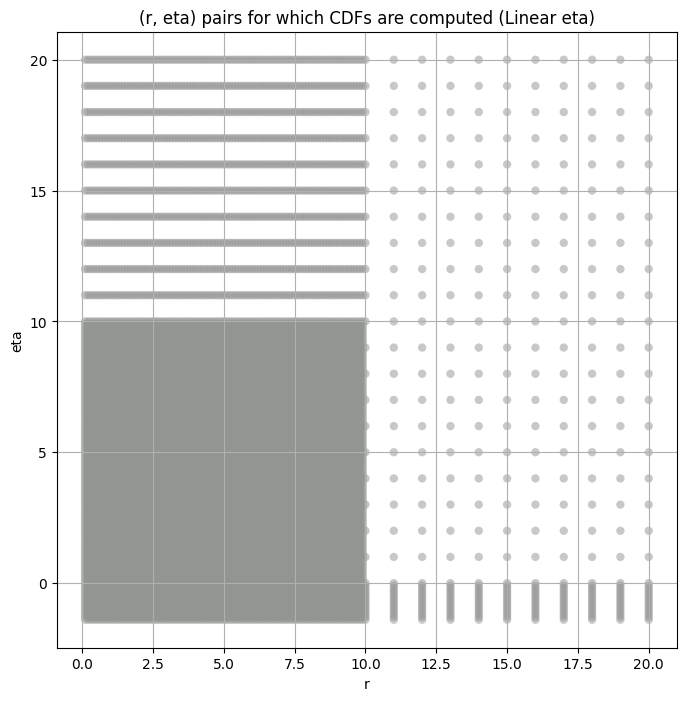

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:33<00:00, 2955.50it/s]


Layer 3


100%|██████████| 100000/100000 [00:42<00:00, 2344.75it/s]


Layer 4


100%|██████████| 100000/100000 [00:44<00:00, 2224.38it/s]


Layer 5


100%|██████████| 100000/100000 [00:44<00:00, 2245.55it/s]


Layer 6


100%|██████████| 100000/100000 [00:47<00:00, 2110.27it/s]


Layer 7


100%|██████████| 100000/100000 [00:47<00:00, 2109.10it/s]


Layer 8


100%|██████████| 100000/100000 [00:46<00:00, 2166.16it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2155.274000  1938.467700  2391.563000   3.322904    1.973814   
3       676.357800   638.532800   716.274900   3.087881    2.314927   
4       188.368770   176.907300   200.277270   3.757729    2.928430   
5        43.769500    40.805225    46.891907   5.373777    4.192946   
6         8.850155     8.162472     9.579076   7.458210    5.558343   
7         1.682264     1.540437     1.835464   9.652344    7.157363   
8         0.272829     0.247420     0.302791  13.286758    8.514162   

       kurt_upper  total_samples  
layer                             
2        4.840138         3180.0  
3        4.010140        12720.0  
4        4.819949        50880.0  
5        6.856130       203520.0  
6       10.405201       814080.0  
7       14.103736      3256320.0  
8       31.882772     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      2155.274000    2155.273926     1699.366089     1482.229248   
3       676.357800     676.357788      619.485474      587.073547   
4       188.368770     188.368774      182.050446      177.949875   
5        43.769500      43.769501       42.709766       41.960464   
6         8.850155       8.850155        8.576219        8.399111   
7         1.682264       1.682264        1.622234        1.583762   
8         0.272829       0.272829        0.260629        0.253588   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1321.752319      1197.358276      1003.977600       853.454468   
3          560.491150       537.969788       498.704071       467.277802   
4          174.487320       171.413849       165.963638       161.214264   
5           41.320744        40.752480        39.768013        38.905903   
6            8.250682         8.119164         7.890609         7.693978   
7            1.551788         1.523737         1.475121         1.433162   
8            0.247831         0.242828         0.234252         0.226929   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           735.442505       638.808228       556.561218       373.196136  
3           440.449188       417.165253       396.437531       343.646851  
4           156.939224       153.110077       149.557449       140.197540  
5            38.134598        37.426521        36.771172        35.038731  
6             7.518616         7.358714         7.211613         6.827391  
7             1.395862         1.362145         1.331203         1.250571  
8             0.220467         0.214653         0.209346         0.195670

####
Layer  2


100%|██████████| 12760/12760 [00:06<00:00, 2113.05it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01745327583790801 2155.274


100%|██████████| 12760/12760 [00:01<00:00, 6871.41it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.017861537653654946 1699.3661


100%|██████████| 12760/12760 [00:01<00:00, 7144.51it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.02572183612010026 1482.2292


100%|██████████| 12760/12760 [00:01<00:00, 6955.54it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.0347163577607722 1321.7523


100%|██████████| 12760/12760 [00:01<00:00, 7238.16it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.042984735594091106 1197.3583


100%|██████████| 12760/12760 [00:01<00:00, 6944.81it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.05958465378572653 1003.9776


100%|██████████| 12760/12760 [00:01<00:00, 7225.08it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07413486936547298 853.45447


100%|██████████| 12760/12760 [00:01<00:00, 7028.89it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.08768396434346859 735.4425


100%|██████████| 12760/12760 [00:01<00:00, 7185.12it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.10223861012939606 638.8082


100%|██████████| 12760/12760 [00:02<00:00, 5303.76it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11628424547915062 556.5612


100%|██████████| 12760/12760 [00:01<00:00, 6698.38it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.15628343100651299 373.19614
Number of samples: 3180, Without approximation : 3180.0


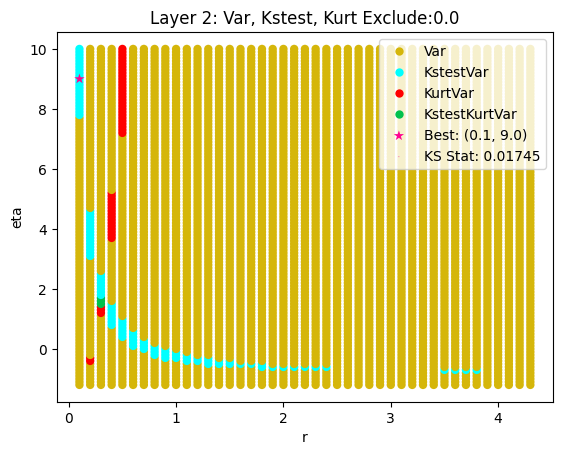

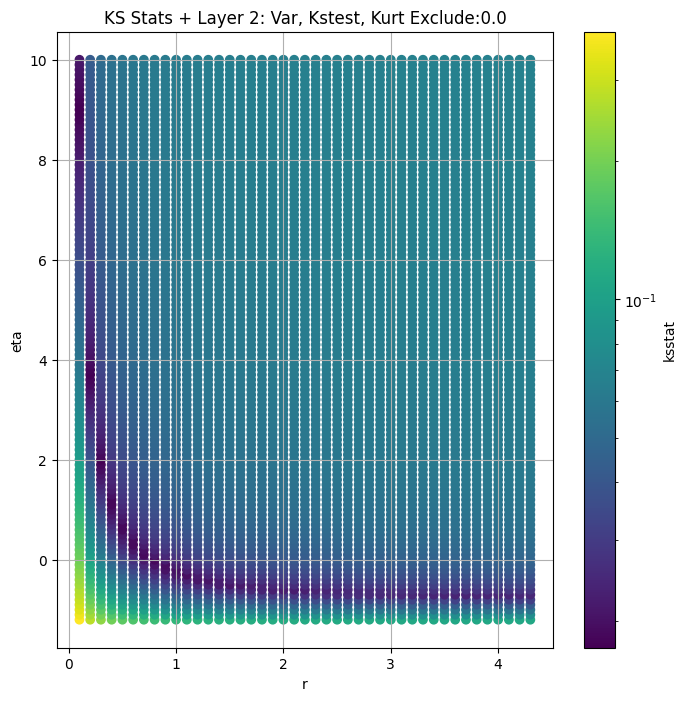

####
Layer  3


100%|██████████| 12760/12760 [00:06<00:00, 2055.62it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.005015704853735148 676.3578


100%|██████████| 12760/12760 [00:06<00:00, 2085.56it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.006747531972166376 619.4855


100%|██████████| 12760/12760 [00:06<00:00, 1852.27it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.008376318494615065 587.07355


100%|██████████| 12760/12760 [00:06<00:00, 2088.60it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.010796312029084043 560.49115


100%|██████████| 12760/12760 [00:06<00:00, 2059.03it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.012595601431558912 537.9698


100%|██████████| 12760/12760 [00:06<00:00, 2053.74it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.01753236422554616 498.70407


100%|██████████| 12760/12760 [00:06<00:00, 2078.49it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.02175432431692348 467.2778


100%|██████████| 12760/12760 [00:06<00:00, 1866.46it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.025854062001830824 440.4492


100%|██████████| 12760/12760 [00:06<00:00, 2025.60it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.029788084356049738 417.16525


100%|██████████| 12760/12760 [00:06<00:00, 2104.43it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03384597692359026 396.43753


100%|██████████| 12760/12760 [00:06<00:00, 2048.60it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.04564551353131541 343.64685
Number of samples: 12720, Without approximation : 12720.0


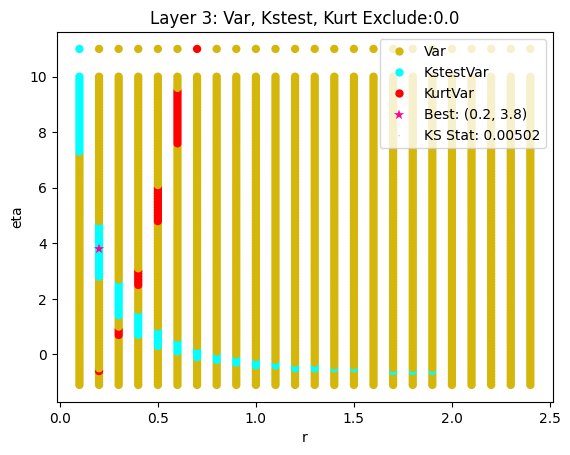

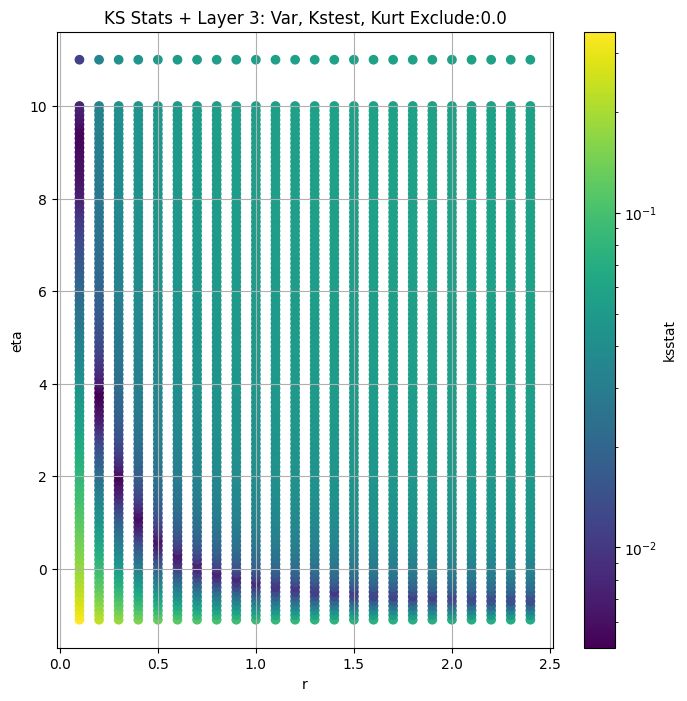

####
Layer  4


100%|██████████| 12760/12760 [00:23<00:00, 541.88it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.00546276442219229 188.36877


100%|██████████| 12760/12760 [00:23<00:00, 534.51it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.005203888419493374 182.05045


100%|██████████| 12760/12760 [00:23<00:00, 546.91it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.005635811329222085 177.94987


100%|██████████| 12760/12760 [00:22<00:00, 571.11it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.005741339272786639 174.48732


100%|██████████| 12760/12760 [00:23<00:00, 543.56it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.006313354501429003 171.41385


100%|██████████| 12760/12760 [00:24<00:00, 528.54it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.006938622769891212 165.96364


100%|██████████| 12760/12760 [00:23<00:00, 548.81it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.008293623780775916 161.21426


100%|██████████| 12760/12760 [00:24<00:00, 523.98it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.009225723065252711 156.93922


100%|██████████| 12760/12760 [00:26<00:00, 486.79it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.0104017086829713 153.11008


100%|██████████| 12760/12760 [00:24<00:00, 525.47it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011512999500268406 149.55745


100%|██████████| 12760/12760 [00:24<00:00, 528.79it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014771519958176493 140.19754
Number of samples: 50880, Without approximation : 50880.0


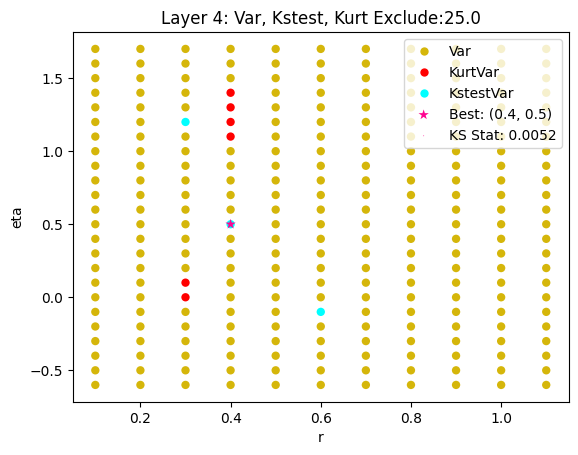

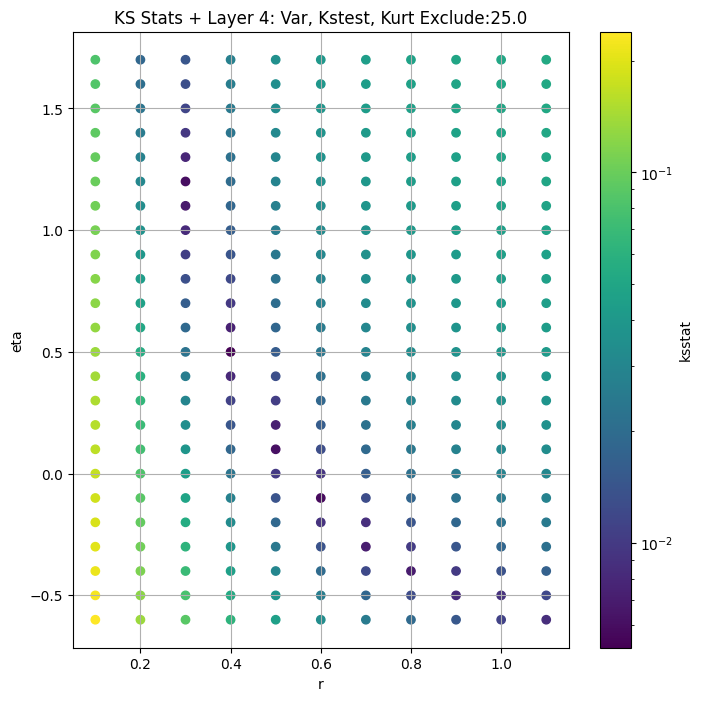

####
Layer  5


100%|██████████| 12760/12760 [00:46<00:00, 276.44it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.0026862646219506514 43.7695


100%|██████████| 12760/12760 [00:47<00:00, 270.85it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.0024912409964499282 42.709766


100%|██████████| 12760/12760 [00:46<00:00, 275.38it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.003444095919913792 41.960464


100%|██████████| 12760/12760 [00:48<00:00, 265.23it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.00361126731461181 41.320744


100%|██████████| 12760/12760 [00:46<00:00, 277.14it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.003254051329645624 40.75248


100%|██████████| 12760/12760 [00:45<00:00, 281.19it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.003954775552571621 39.768013


100%|██████████| 12760/12760 [00:47<00:00, 270.36it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.004874006701845568 38.905903


100%|██████████| 12760/12760 [00:45<00:00, 283.49it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.00525338555339655 38.134598


100%|██████████| 12760/12760 [00:45<00:00, 279.53it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.005826887340599773 37.42652


100%|██████████| 12760/12760 [00:45<00:00, 280.73it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006464102616910772 36.77117


100%|██████████| 12760/12760 [00:51<00:00, 246.58it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008176398501872906 35.03873
Number of samples: 100000, Without approximation : 203520.0


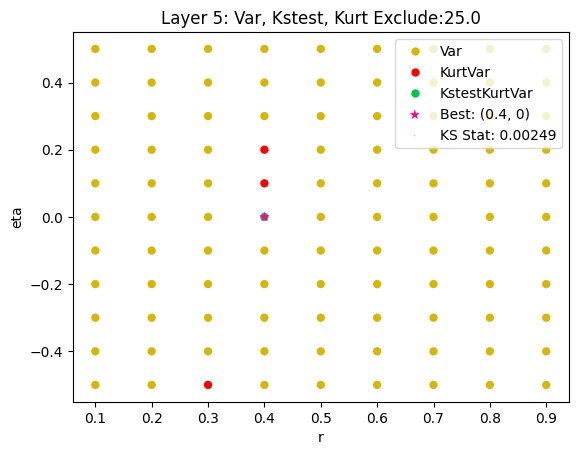

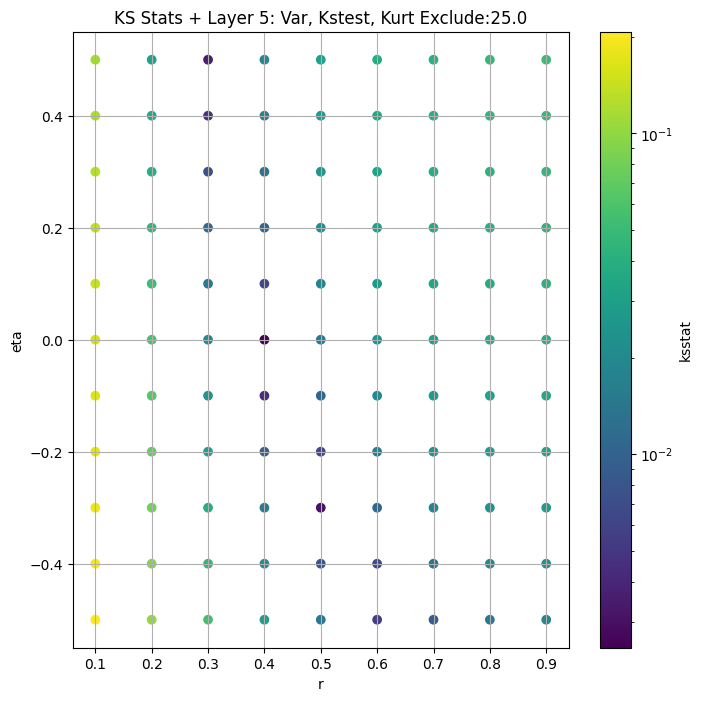

####
Layer  6


100%|██████████| 12760/12760 [00:47<00:00, 267.13it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.0037182066153217397 8.850155


100%|██████████| 12760/12760 [00:44<00:00, 287.73it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.0042005004912470945 8.576219


100%|██████████| 12760/12760 [00:46<00:00, 275.53it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.004786463349072179 8.399111


100%|██████████| 12760/12760 [00:45<00:00, 278.09it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.005291646153042118 8.250682


100%|██████████| 12760/12760 [00:46<00:00, 272.40it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.004469170870650685 8.119164


100%|██████████| 12760/12760 [00:50<00:00, 253.41it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.0047023528164451545 7.8906093


100%|██████████| 12760/12760 [00:46<00:00, 275.95it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005408569908973648 7.693978


100%|██████████| 12760/12760 [00:45<00:00, 279.90it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.005592505188291463 7.5186157


100%|██████████| 12760/12760 [00:45<00:00, 281.86it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006438218619596814 7.358714


100%|██████████| 12760/12760 [00:45<00:00, 280.67it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.007294638415200616 7.211613


100%|██████████| 12760/12760 [00:45<00:00, 281.42it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008625286947526178 6.8273907
Number of samples: 100000, Without approximation : 814080.0


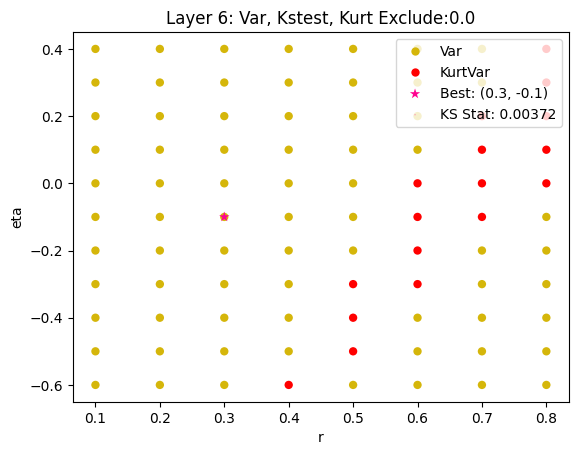

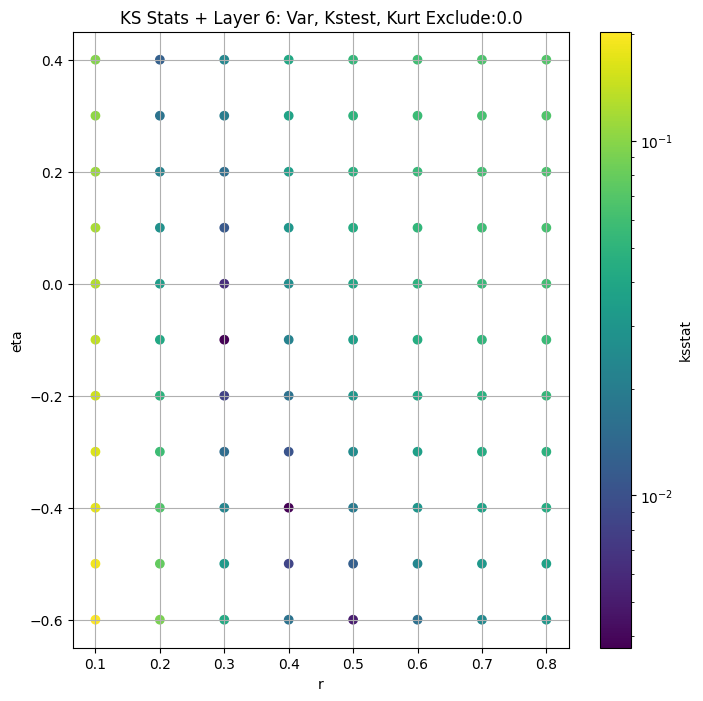

####
Layer  7


100%|██████████| 12760/12760 [00:45<00:00, 282.15it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.005648261353650819 1.6822643


100%|██████████| 12760/12760 [00:45<00:00, 280.44it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.006685463543571024 1.6222337


100%|██████████| 12760/12760 [00:51<00:00, 249.17it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.0061250622582377234 1.5837616


100%|██████████| 12760/12760 [00:48<00:00, 260.51it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.005916549155919992 1.5517884


100%|██████████| 12760/12760 [00:49<00:00, 256.65it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006814875214231075 1.5237372


100%|██████████| 12760/12760 [00:47<00:00, 267.05it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.008334655381078582 1.4751208


100%|██████████| 12760/12760 [00:44<00:00, 283.92it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.007271472249399169 1.4331622


100%|██████████| 12760/12760 [00:44<00:00, 284.53it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.007850045947636886 1.3958615


100%|██████████| 12760/12760 [00:43<00:00, 294.64it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.008459019071858809 1.3621447


100%|██████████| 12760/12760 [00:43<00:00, 293.70it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.009265669410793431 1.3312027


100%|██████████| 12760/12760 [00:43<00:00, 292.79it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.009802112367185978 1.2505714
Number of samples: 100000, Without approximation : 3256320.0


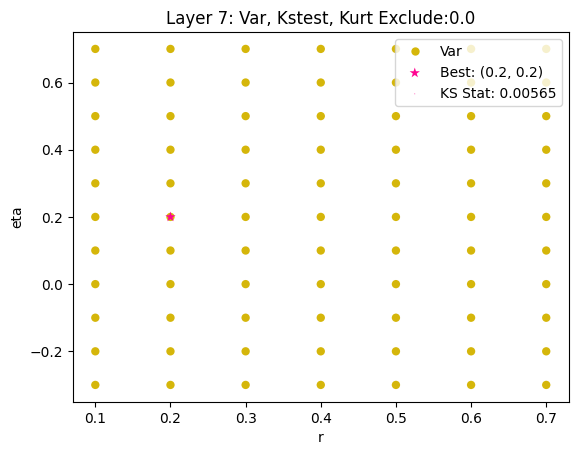

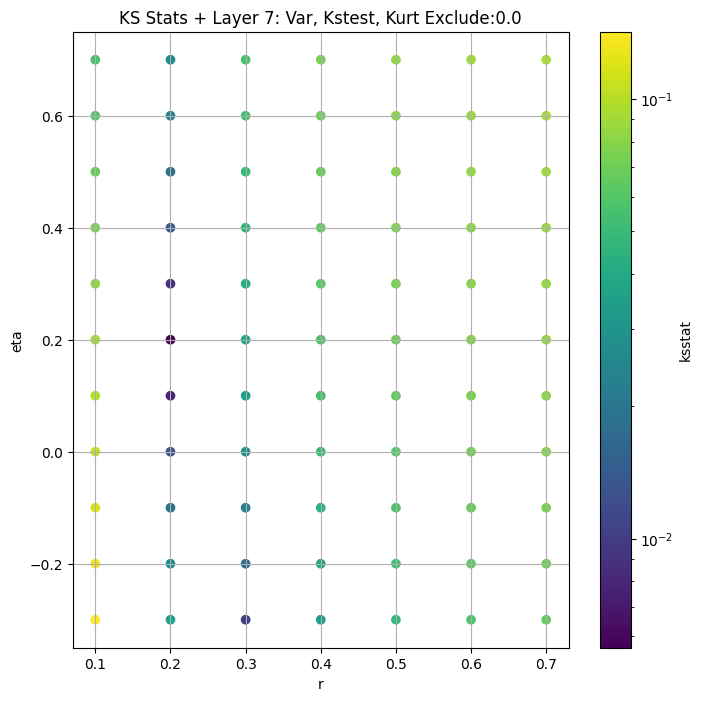

####
Layer  8


100%|██████████| 12760/12760 [00:43<00:00, 294.29it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.00640114026492089 0.27282932


100%|██████████| 12760/12760 [00:43<00:00, 294.19it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.007111484494128906 0.26062876


100%|██████████| 12760/12760 [00:43<00:00, 294.67it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.00682145034133641 0.25358832


100%|██████████| 12760/12760 [00:43<00:00, 293.83it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.006762433872164131 0.2478307


100%|██████████| 12760/12760 [00:43<00:00, 294.83it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.007635016659739979 0.24282788


100%|██████████| 12760/12760 [00:43<00:00, 294.29it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.008352140696513799 0.23425205


100%|██████████| 12760/12760 [00:46<00:00, 275.26it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.007826767429527037 0.22692919


100%|██████████| 12760/12760 [00:48<00:00, 260.51it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009020777994980023 0.22046717


100%|██████████| 12760/12760 [00:46<00:00, 274.91it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.009412969146881167 0.21465307


100%|██████████| 12760/12760 [00:47<00:00, 267.47it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.00924280104059394 0.20934577


100%|██████████| 12760/12760 [00:46<00:00, 275.28it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.011402451748567022 0.19567004
Number of samples: 100000, Without approximation : 13025280.0


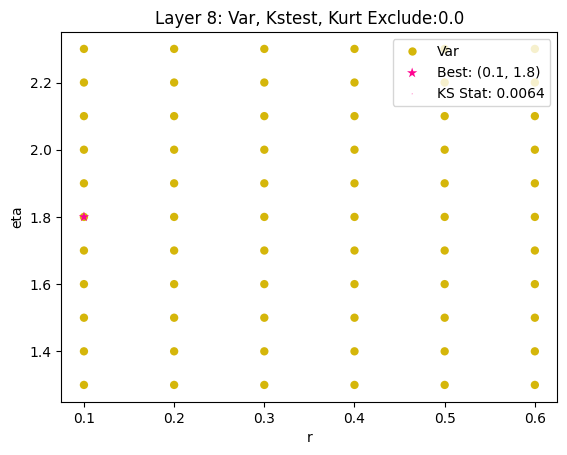

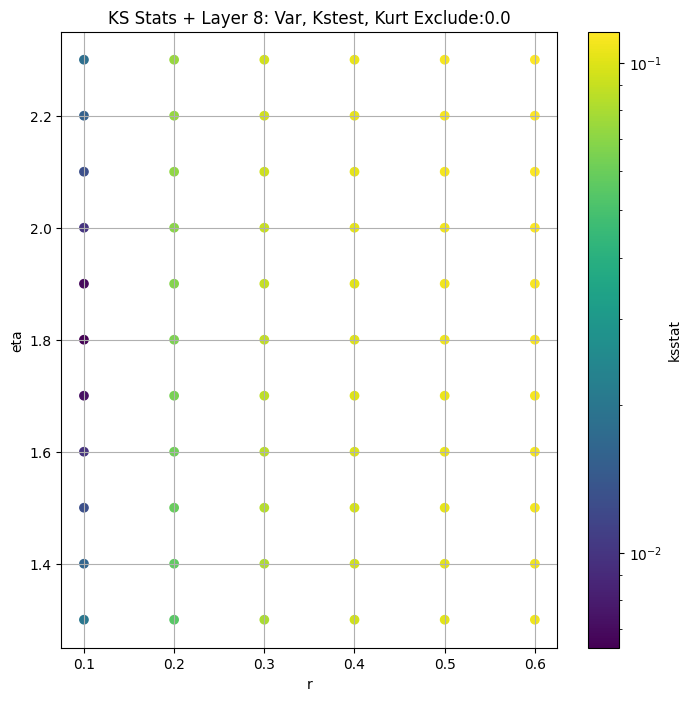

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2155.274000  1938.467700  2391.563000   3.322904    1.973814   
3       676.357800   638.532800   716.274900   3.087881    2.314927   
4       188.368770   176.907300   200.277270   3.757729    2.928430   
5        43.769500    40.805225    46.891907   5.373777    4.192946   
6         8.850155     8.162472     9.579076   7.458210    5.558343   
7         1.682264     1.540437     1.835464   9.652344    7.157363   
8         0.272829     0.247420     0.302791  13.286758    8.514162   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.840138         3180.0             0.017453        0.1          9.0   
3        4.010140        12720.0             0.005016        0.2          3.8   
4        4.819949        50880.0             0.005204        0.4          0.5   
5        6.856130       203520.0             0.002491        0.4          0.0   
6       10.405201       814080.0             0.003718        0.3         -0.1   
7       14.103736      3256320.0             0.005648        0.2          0.2   
8       31.882772     13025280.0             0.006401        0.1          1.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       8.726826e-18                     0.0         2155.274000   
3       3.619355e-05                     0.0          676.357800   
4       2.334910e+00                    25.0          182.050450   
5       1.021875e+00                    25.0           42.709766   
6       2.583298e-02                     0.0            8.850155   
7       1.380240e-05                     0.0            1.682264   
8       5.109573e-17                     0.0            0.272829   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 522/522 [00:00<00:00, 1959.45it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.04543248836767266, var: 1197.3582763671875


100%|██████████| 522/522 [00:00<00:00, 6757.36it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.035942301273061084, var: 1321.7523193359375


100%|██████████| 522/522 [00:00<00:00, 6330.02it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.027987080363133243, var: 1482.229248046875


100%|██████████| 522/522 [00:00<00:00, 6602.18it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.020985521160590548, var: 1699.3660888671875


100%|██████████| 522/522 [00:00<00:00, 6894.46it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01745327583790801, var: 2155.27392578125
Number of samples: 3180, Without approximation : 3180.0


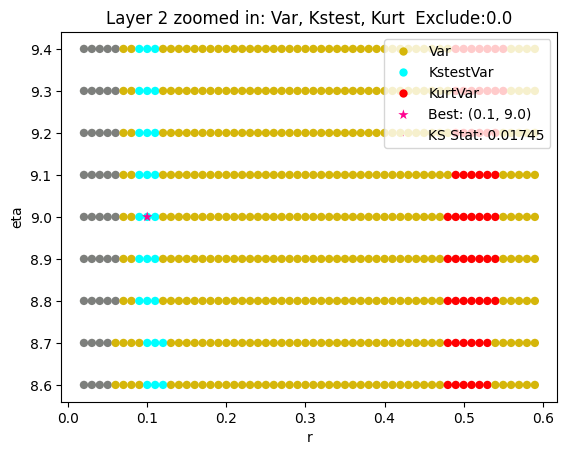

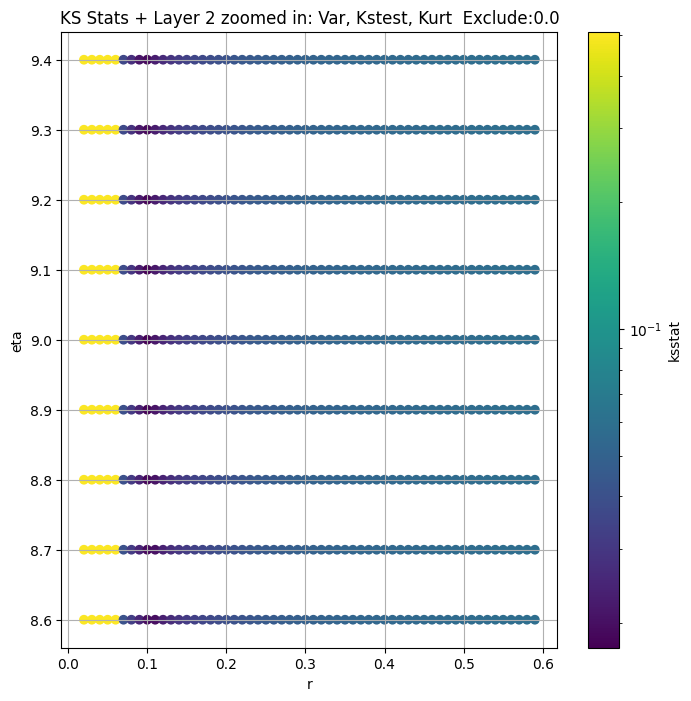

Layer 3


100%|██████████| 621/621 [00:00<00:00, 1084.82it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01579120965507408, var: 537.9697875976562


100%|██████████| 621/621 [00:00<00:00, 2044.50it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.01333996108997293, var: 560.4911499023438


100%|██████████| 621/621 [00:00<00:00, 2029.70it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010904917242248846, var: 587.0735473632812


100%|██████████| 621/621 [00:00<00:00, 1839.14it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.008457350151467868, var: 619.4854736328125


100%|██████████| 621/621 [00:00<00:00, 1755.80it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0050035549329717766, var: 676.3577880859375
Number of samples: 12720, Without approximation : 12720.0


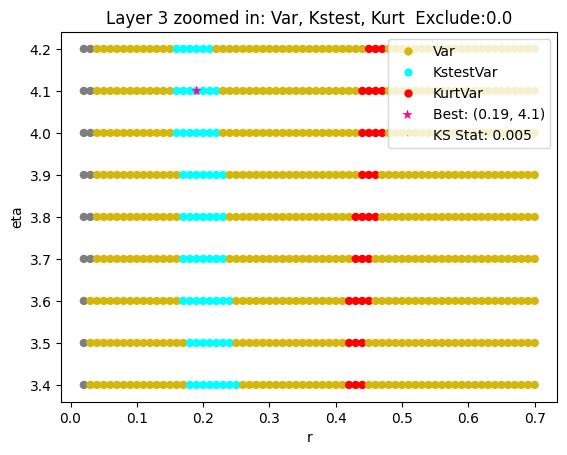

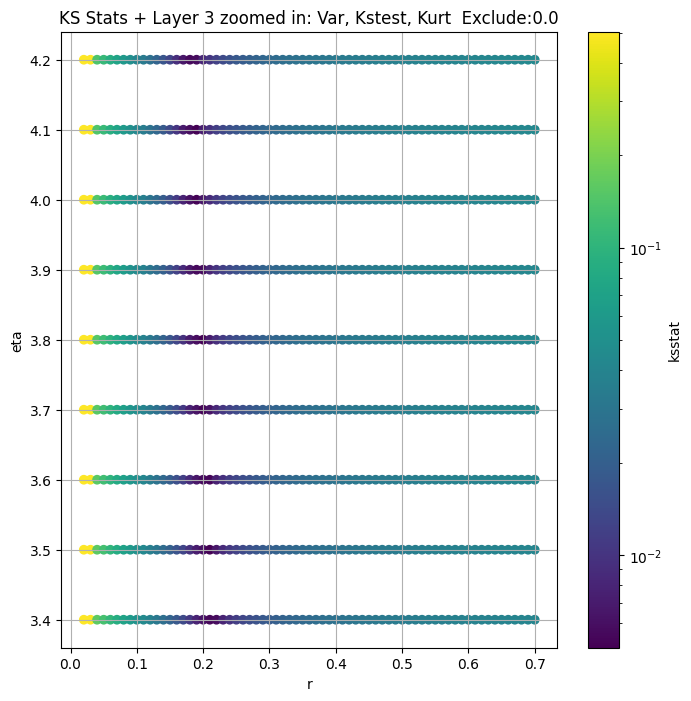

Layer 4


100%|██████████| 792/792 [00:01<00:00, 452.59it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.007779265308306971, var: 168.57272338867188


100%|██████████| 792/792 [00:01<00:00, 525.31it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.0070315069536242, var: 171.41384887695312


100%|██████████| 792/792 [00:01<00:00, 503.59it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.006294857314736668, var: 174.48731994628906


100%|██████████| 792/792 [00:01<00:00, 546.20it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.005505983059539754, var: 177.9498748779297


100%|██████████| 792/792 [00:01<00:00, 537.05it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.005033186980521742, var: 182.05044555664062


100%|██████████| 792/792 [00:01<00:00, 566.43it/s]


Finding Minimum after computing 792 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.005108027452705777, var: 188.3687744140625
Number of samples: 50880, Without approximation : 50880.0


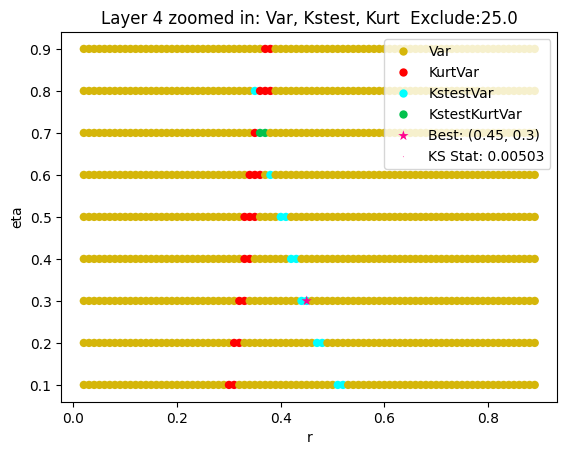

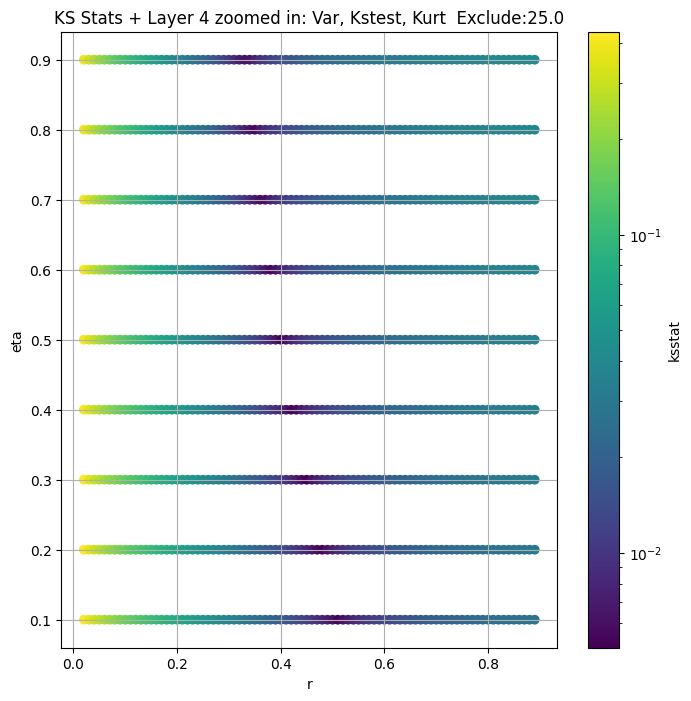

Layer 5


100%|██████████| 1152/1152 [00:04<00:00, 242.96it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.0037052065933609324, var: 40.242618560791016


100%|██████████| 1152/1152 [00:04<00:00, 279.38it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.003245268338619156, var: 40.752479553222656


100%|██████████| 1152/1152 [00:04<00:00, 256.87it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.0029519161683977113, var: 41.320743560791016


100%|██████████| 1152/1152 [00:04<00:00, 270.18it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.00247789315216862, var: 41.96046447753906


100%|██████████| 1152/1152 [00:04<00:00, 245.41it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.002212068864410499, var: 42.70976638793945


100%|██████████| 1152/1152 [00:04<00:00, 249.46it/s]


Finding Minimum after computing 1152 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.0019413088238501297, var: 43.769500732421875
Number of samples: 100000, Without approximation : 203520.0


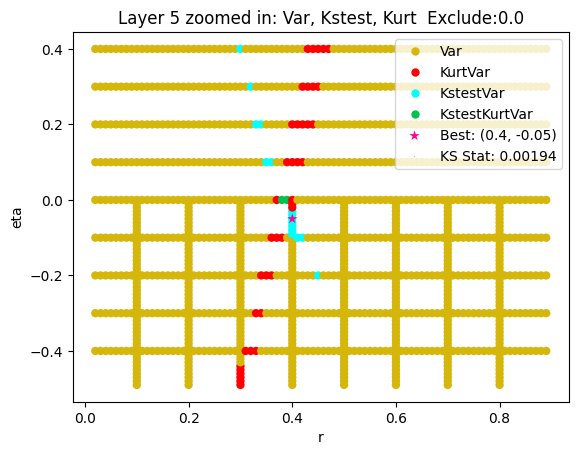

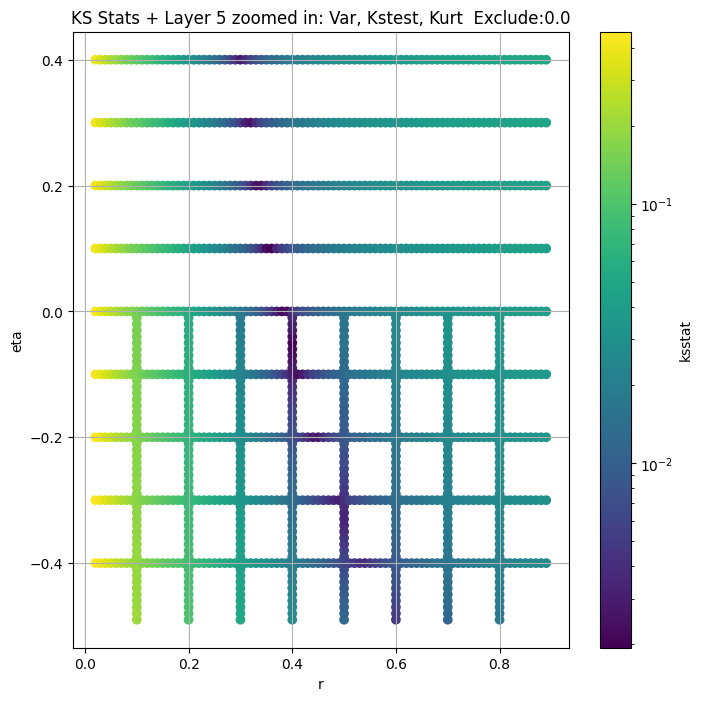

Layer 6


100%|██████████| 1080/1080 [00:04<00:00, 239.27it/s]


Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.003771107018174513, var: 8.11916446685791


100%|██████████| 1080/1080 [00:04<00:00, 218.32it/s]


Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.0038195082990104545, var: 8.25068187713623


100%|██████████| 1080/1080 [00:03<00:00, 290.62it/s]


Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.003262557868873528, var: 8.399110794067383


100%|██████████| 1080/1080 [00:03<00:00, 293.27it/s]


Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.0031397376915973108, var: 8.576218605041504


100%|██████████| 1080/1080 [00:03<00:00, 291.54it/s]


Finding Minimum after computing 1080 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.0030240070288261034, var: 8.850154876708984
Number of samples: 100000, Without approximation : 814080.0


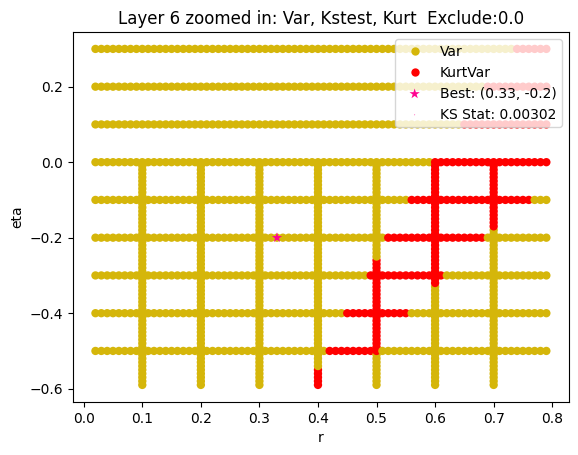

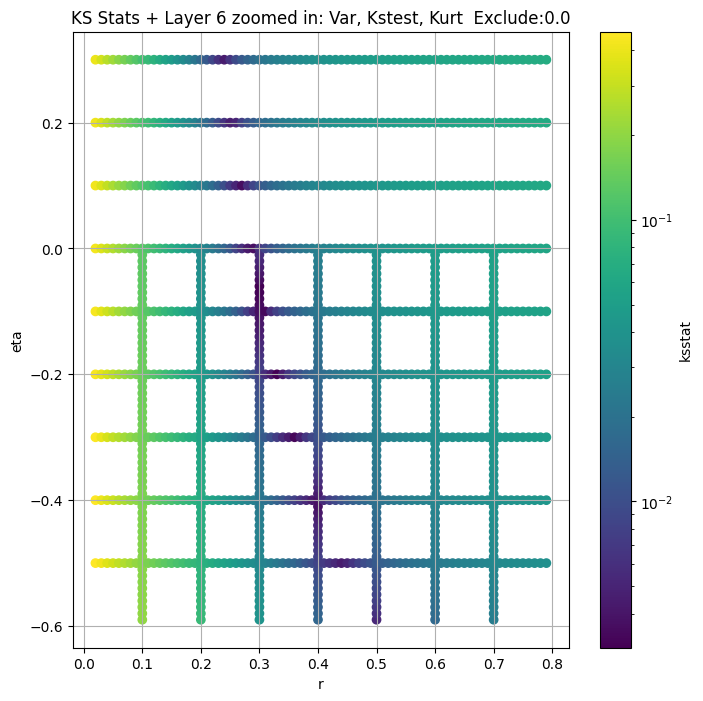

Layer 7


100%|██████████| 879/879 [00:03<00:00, 289.52it/s]


Finding Minimum after computing 879 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.006422153722766888, var: 1.5237371921539307


100%|██████████| 879/879 [00:03<00:00, 287.89it/s]


Finding Minimum after computing 879 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.005780977663614739, var: 1.5517884492874146


100%|██████████| 879/879 [00:03<00:00, 291.32it/s]


Finding Minimum after computing 879 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.00599299625842642, var: 1.5837615728378296


100%|██████████| 879/879 [00:02<00:00, 296.64it/s]


Finding Minimum after computing 879 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.005321592226907312, var: 1.6222337484359741


100%|██████████| 879/879 [00:03<00:00, 290.78it/s]


Finding Minimum after computing 879 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.004926787758326556, var: 1.6822643280029297
Number of samples: 100000, Without approximation : 3256320.0


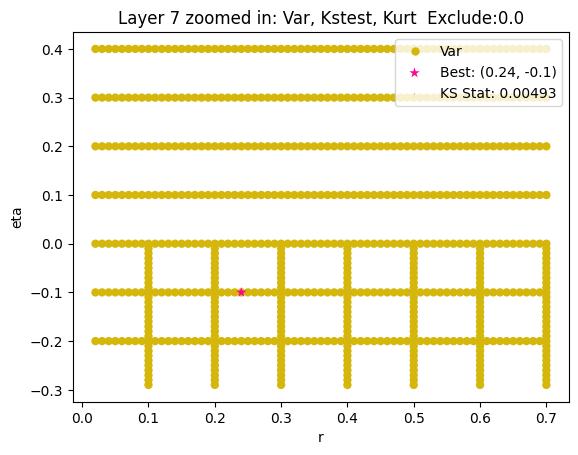

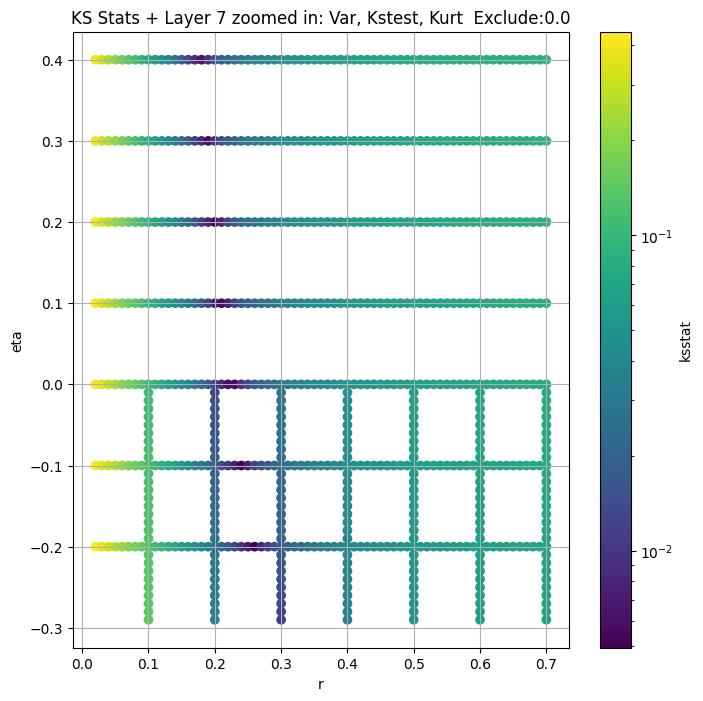

Layer 8


100%|██████████| 580/580 [00:02<00:00, 250.46it/s]


Finding Minimum after computing 580 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.008607763578578176, var: 0.2428278774023056


100%|██████████| 580/580 [00:01<00:00, 295.70it/s]


Finding Minimum after computing 580 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.008079654238440148, var: 0.24783070385456085


100%|██████████| 580/580 [00:01<00:00, 290.68it/s]


Finding Minimum after computing 580 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.007719904440109282, var: 0.25358831882476807


100%|██████████| 580/580 [00:01<00:00, 293.47it/s]


Finding Minimum after computing 580 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.007111484494128906, var: 0.26062875986099243


100%|██████████| 580/580 [00:01<00:00, 290.43it/s]


Finding Minimum after computing 580 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.005977623712642655, var: 0.2728293240070343
Number of samples: 100000, Without approximation : 13025280.0


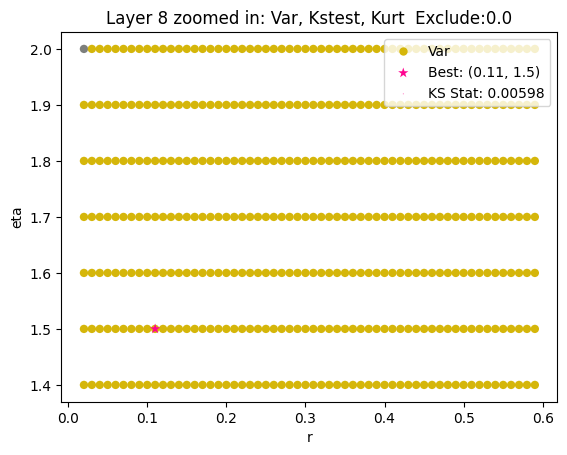

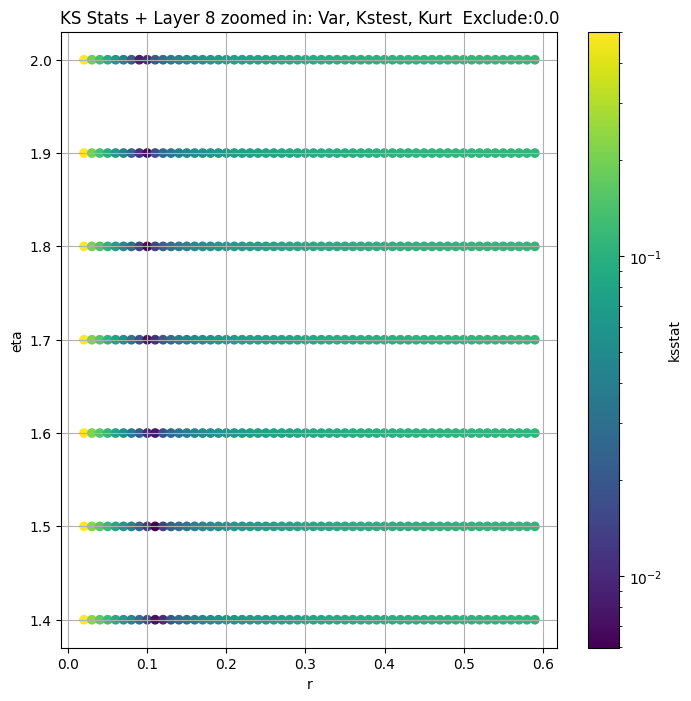

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2155.274000  1938.467700  2391.563000   3.322904    1.973814   
3       676.357800   638.532800   716.274900   3.087881    2.314927   
4       188.368770   176.907300   200.277270   3.757729    2.928430   
5        43.769500    40.805225    46.891907   5.373777    4.192946   
6         8.850155     8.162472     9.579076   7.458210    5.558343   
7         1.682264     1.540437     1.835464   9.652344    7.157363   
8         0.272829     0.247420     0.302791  13.286758    8.514162   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.840138         3180.0             0.017453        0.1          9.0   
3        4.010140        12720.0             0.005016        0.2          3.8   
4        4.819949        50880.0             0.005204        0.4          0.5   
5        6.856130       203520.0             0.002491        0.4          0.0   
6       10.405201       814080.0             0.003718        0.3         -0.1   
7       14.103736      3256320.0             0.005648        0.2          0.2   
8       31.882772     13025280.0             0.006401        0.1          1.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       8.726826e-18                     0.0         2155.274000   
3       3.619355e-05                     0.0          676.357788   
4       2.334910e+00                    25.0          182.050446   
5       1.021875e+00                    25.0           43.769501   
6       2.583298e-02                     0.0            8.850155   
7       1.380240e-05                     0.0            1.682264   
8       5.109573e-17                     0.0            0.272829   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.017453    0.10      9.00   
3                     0.012029          0.005004    0.19      4.10   
4                     0.006018          0.005033    0.45      0.30   
5                     0.003010          0.001941    0.40     -0.05   
6                     0.001505          0.003024    0.33     -0.20   
7                     0.000753          0.004927    0.24     -0.10   
8                     0.000376          0.005978    0.11      1.50   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      8.726826e-18                  0.0         6034  
3      8.694740e-06                  0.0        72444  
4      6.202770e+00                 25.0        76320  
5      1.125457e+00                  0.0       515160  
6      7.236877e-02                  0.0       203520  
7      4.196859e-04                  0.0        76320  
8      7.104264e-15                  0.0        50880

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

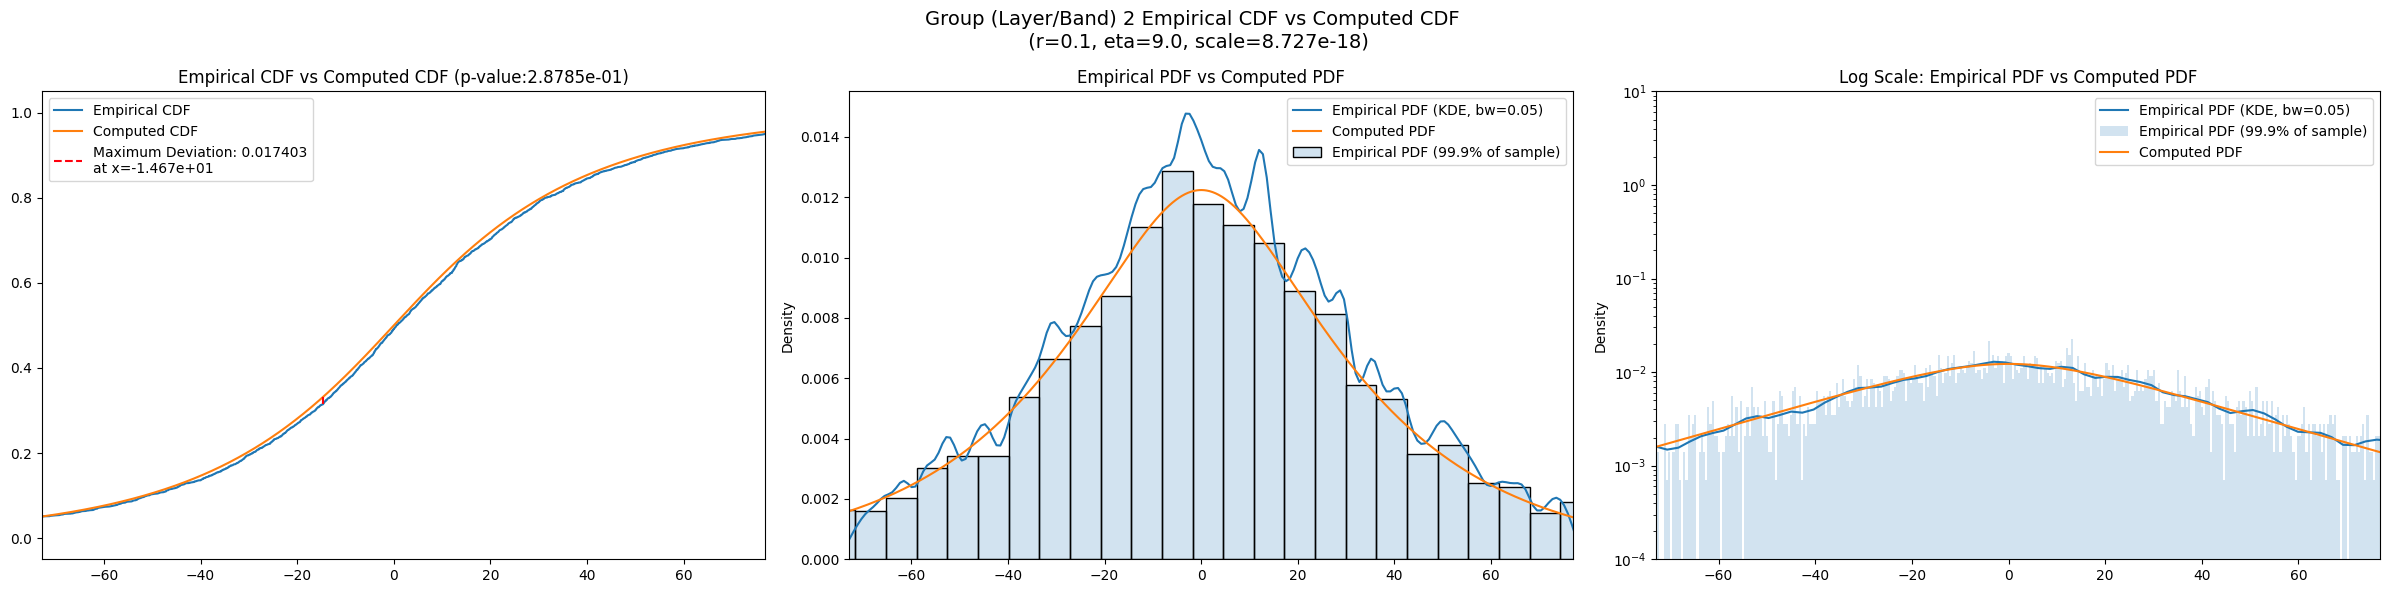

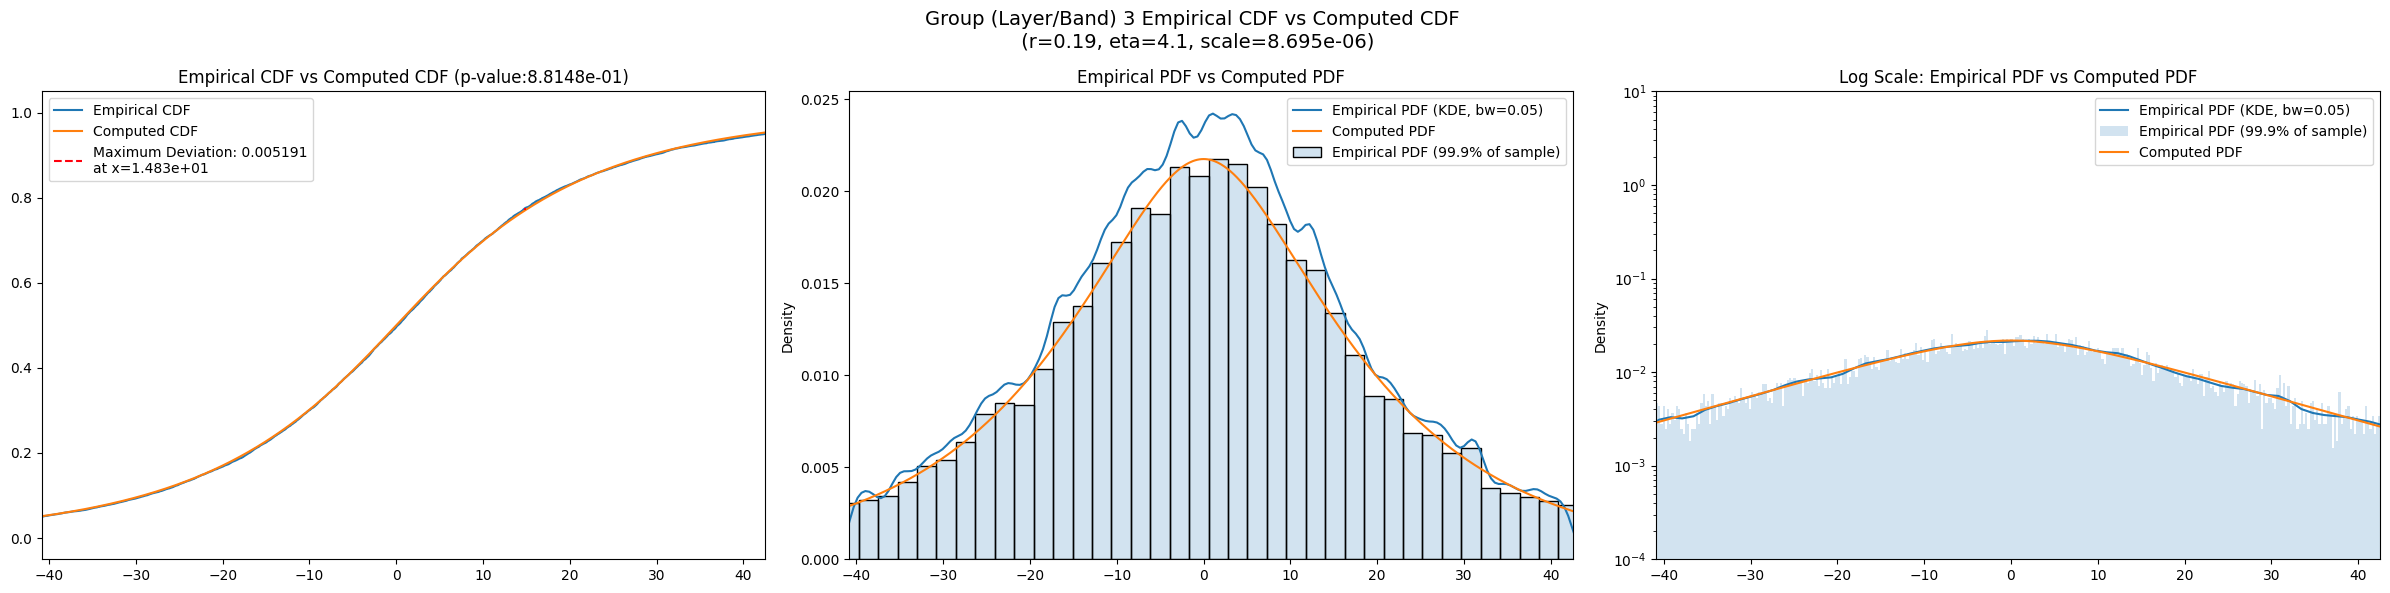

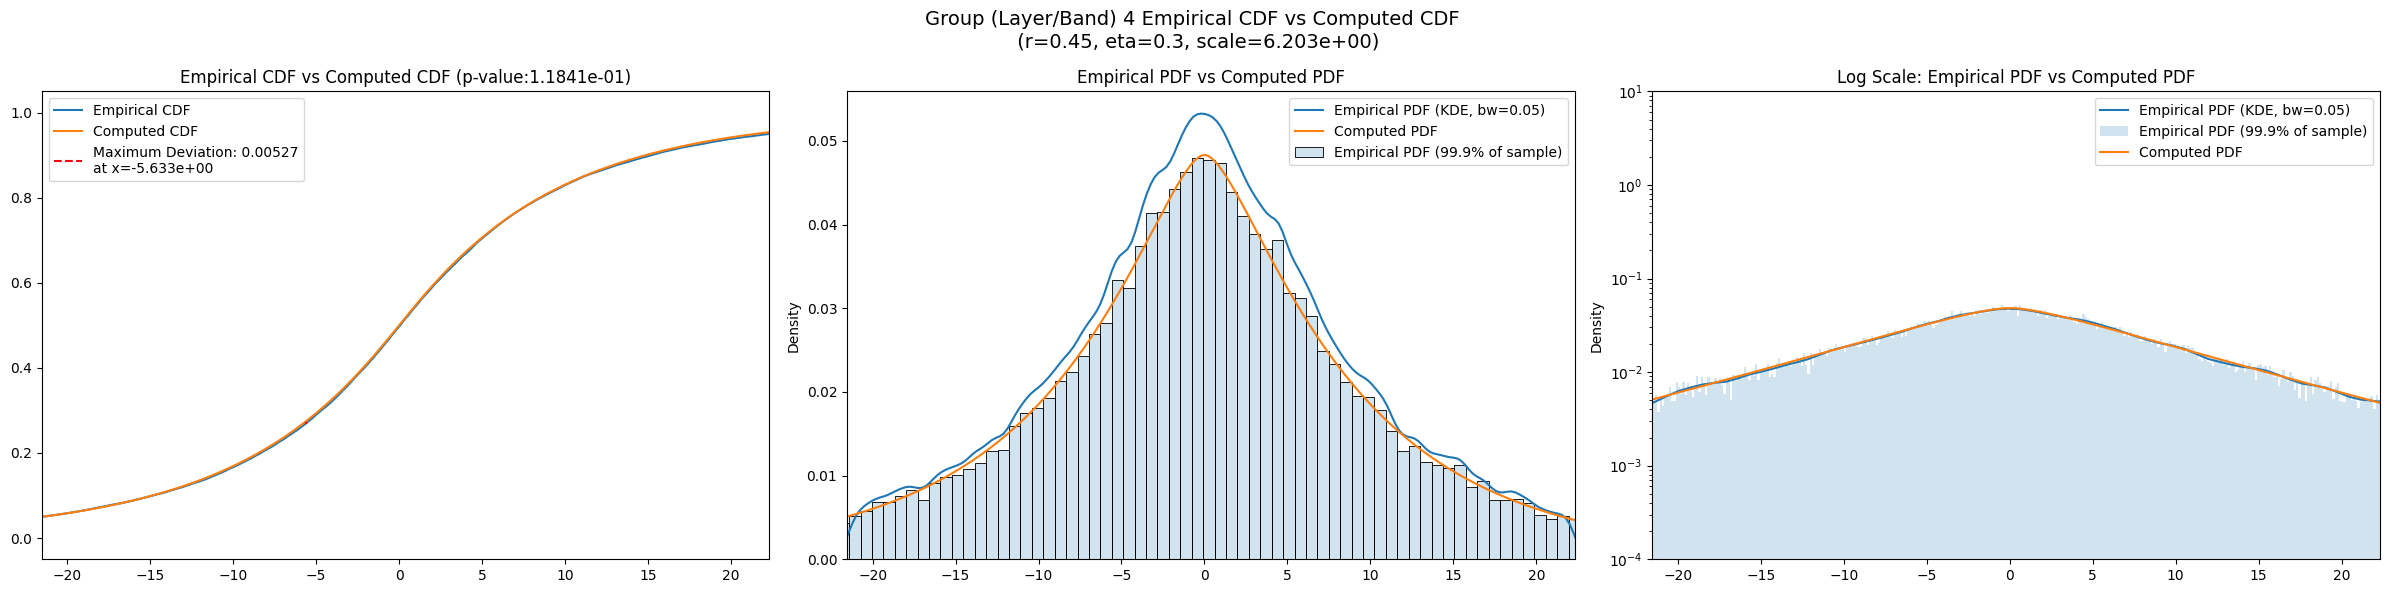

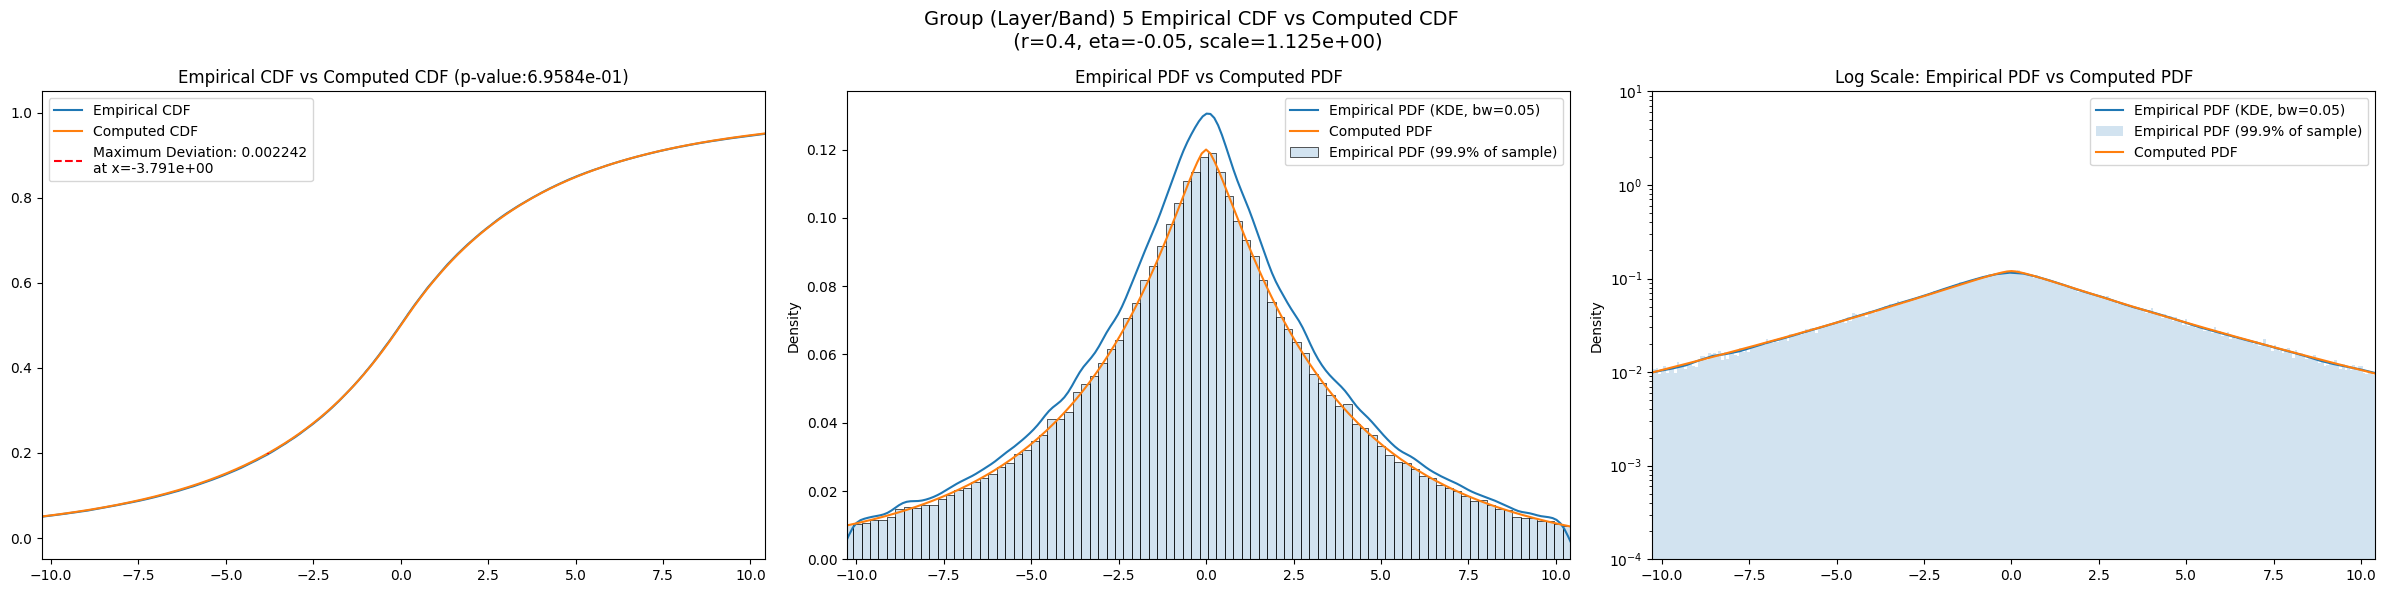

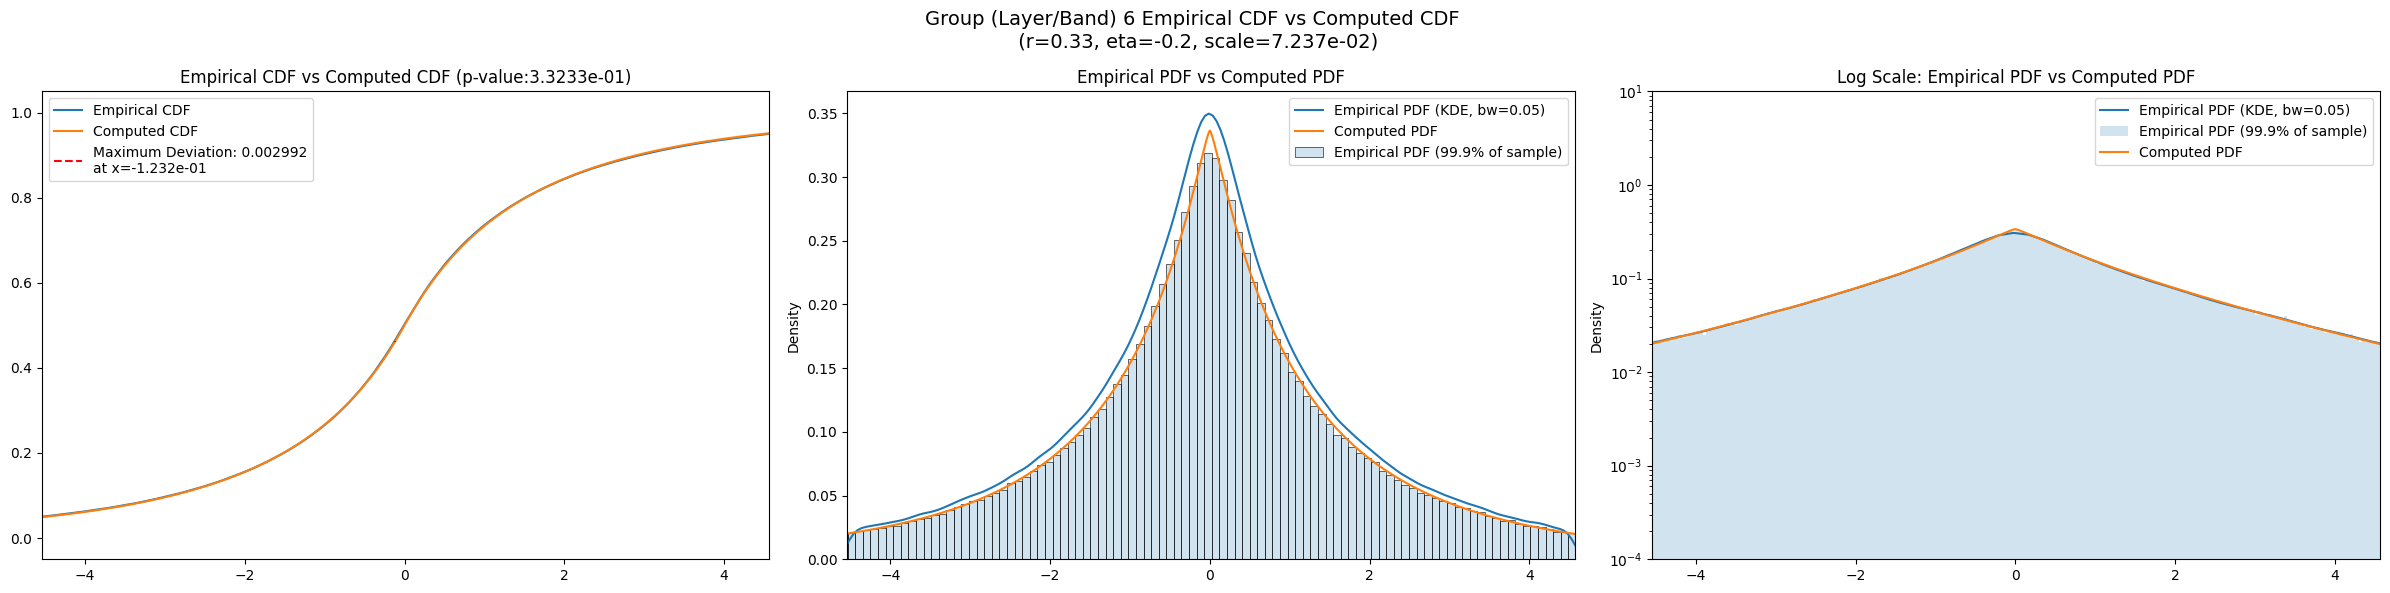

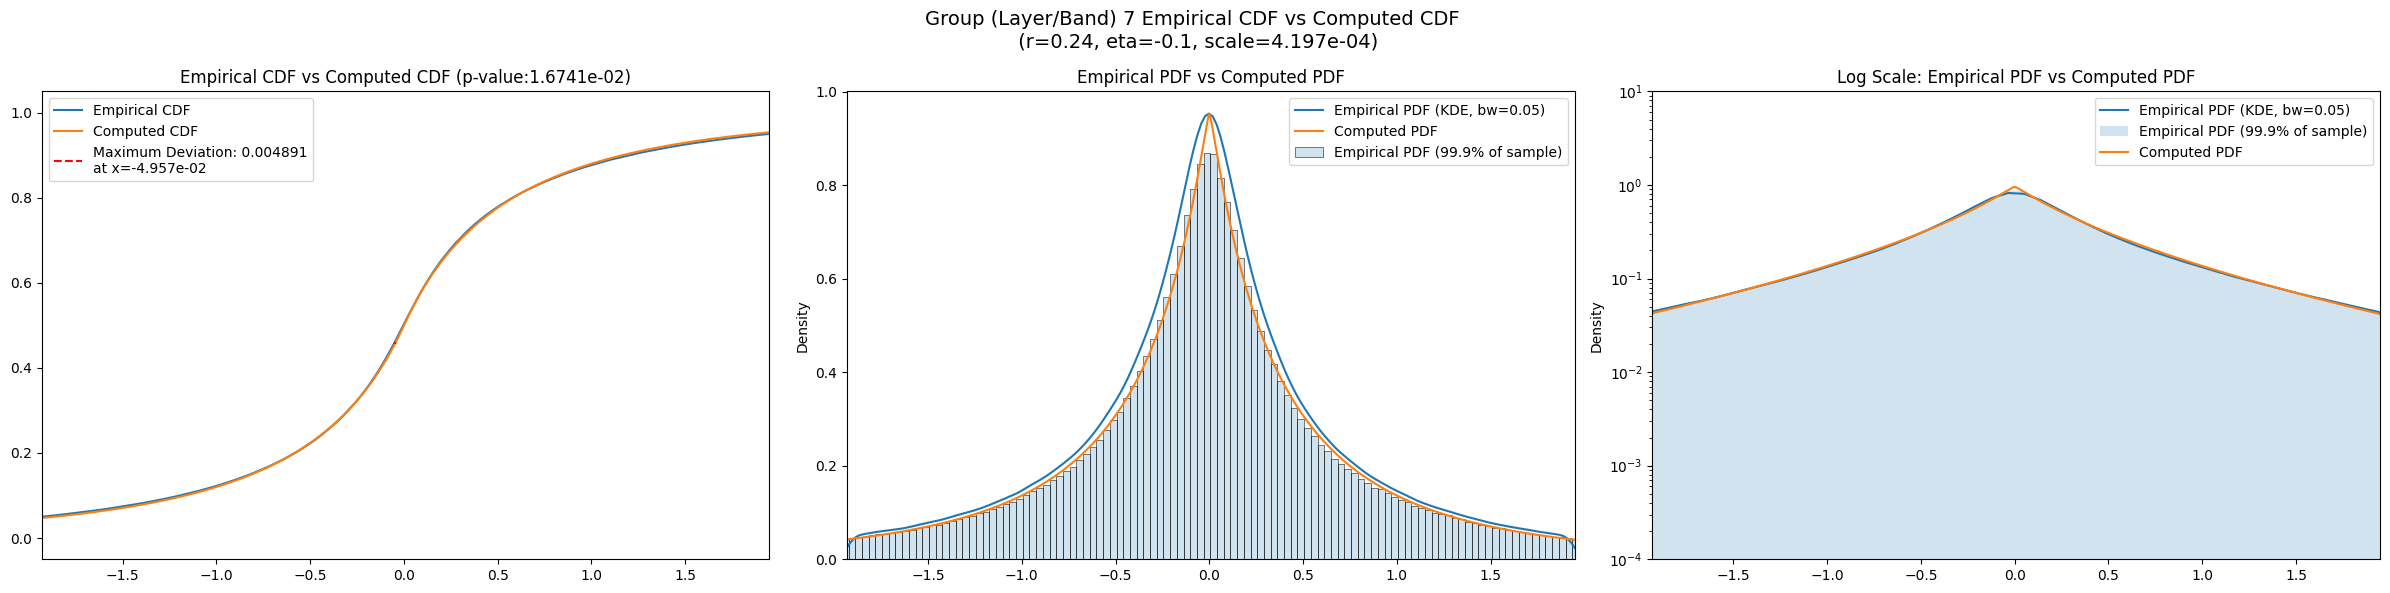

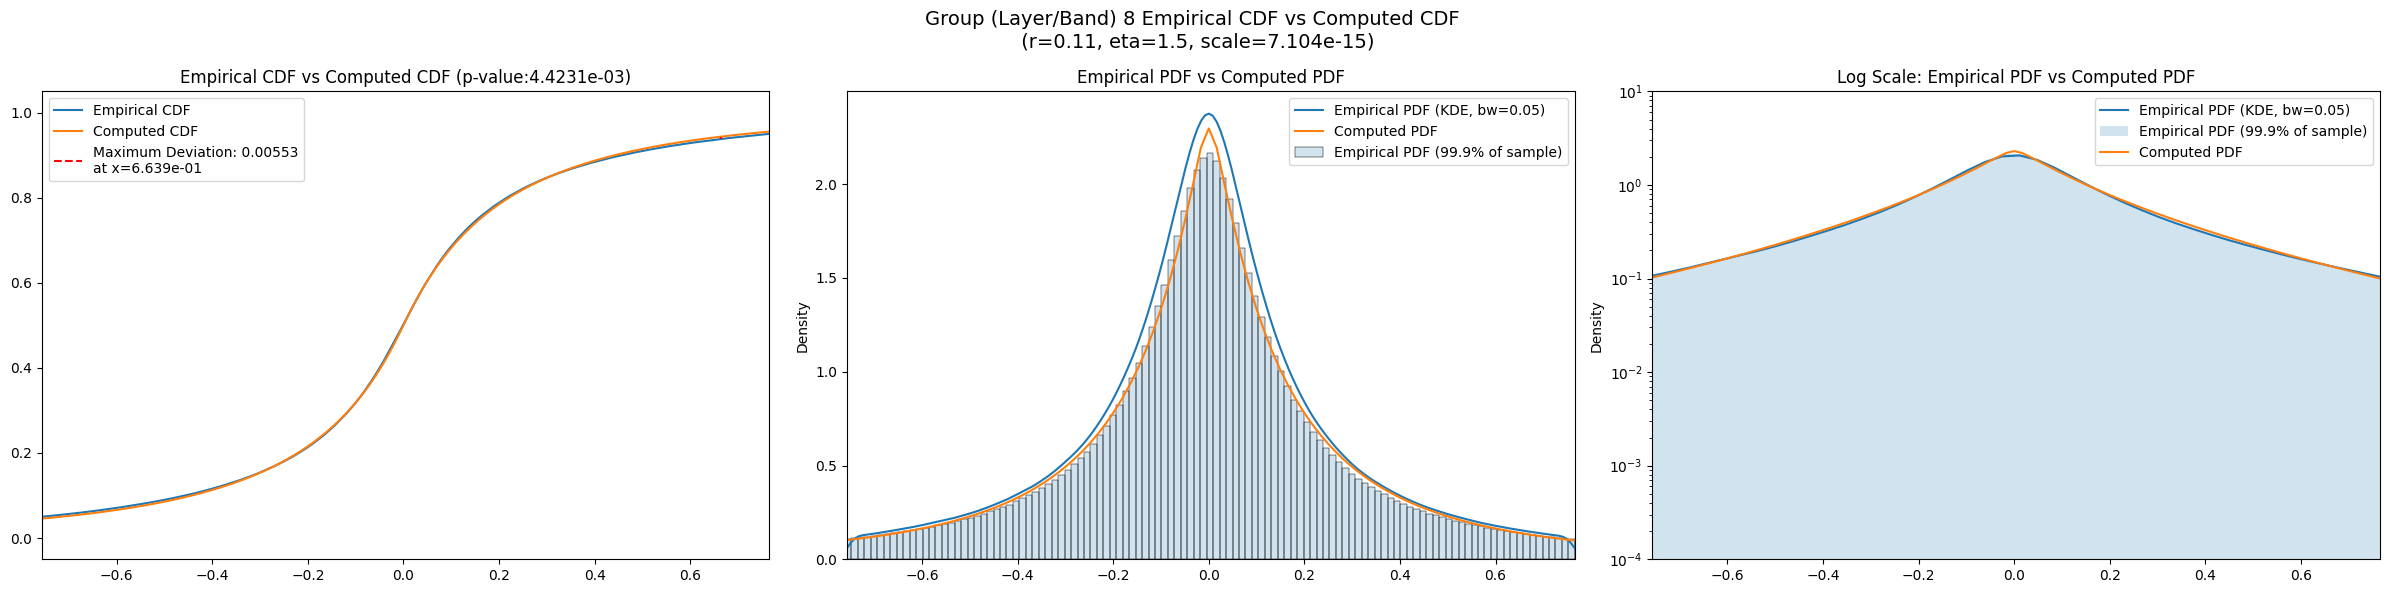

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2155.274000  1938.467700  2391.563000   3.322904    1.973814   
3       676.357800   638.532800   716.274900   3.087881    2.314927   
4       188.368770   176.907300   200.277270   3.757729    2.928430   
5        43.769500    40.805225    46.891907   5.373777    4.192946   
6         8.850155     8.162472     9.579076   7.458210    5.558343   
7         1.682264     1.540437     1.835464   9.652344    7.157363   
8         0.272829     0.247420     0.302791  13.286758    8.514162   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.840138         3180.0             0.017453        0.1          9.0   
3        4.010140        12720.0             0.005016        0.2          3.8   
4        4.819949        50880.0             0.005204        0.4          0.5   
5        6.856130       203520.0             0.002491        0.4          0.0   
6       10.405201       814080.0             0.003718        0.3         -0.1   
7       14.103736      3256320.0             0.005648        0.2          0.2   
8       31.882772     13025280.0             0.006401        0.1          1.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       37.459900              0.033191          1.770360e-03   
3      ...       21.885000              0.024858          2.923830e-07   
4      ...       10.736800              0.032032          8.652880e-46   
5      ...        4.818820              0.035863         7.252520e-228   
6      ...        1.949470              0.043669          0.000000e+00   
7      ...        0.759319              0.051366          0.000000e+00   
8      ...        0.292005              0.051989          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          34.985500             0.023336         6.166270e-02  28.772800   
3          19.242100             0.011831         5.636570e-02  15.361200   
4           9.417710             0.006597         2.375970e-02   7.733470   
5           4.228910             0.008164         3.285670e-12   3.439560   
6           1.710210             0.015925        9.249080e-180   1.377680   
7           0.666694             0.023846         0.000000e+00   0.532163   
8           0.257444             0.024992         0.000000e+00   0.204989   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018743   2.112330e-01          2.840127e-01  
3           0.012472   3.791330e-02          9.060960e-01  
4           0.009062   4.665810e-04          1.512943e-01  
5           0.010621   2.265200e-20          4.264806e-01  
6           0.017913  2.374930e-227          6.822995e-07  
7           0.024293   0.000000e+00          4.416625e-69  
8           0.023123   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.017453                 0.024030          0.017453   
3                 0.005016                 0.012029          0.005004   
4                 0.005204                 0.006018          0.005033   
5                 0.002491                 0.003010          0.001941   
6                 0.003718                 0.001505          0.003024   
7                 0.005648                 0.000753          0.004927   
8                 0.006401                 0.000376          0.005978   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.033191             0.023336       0.018743  
3                  0.024858             0.011831       0.012472  
4                  0.032032             0.006597       0.009062  
5                  0.035863             0.008164       0.010621  
6                  0.043669             0.015925       0.017913  
7                  0.051366             0.023846       0.024293  
8                  0.051989             0.024992       0.023123

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             2155.274000          0.017453    0.10      9.00  8.726826e-18   
3              676.357788          0.005004    0.19      4.10  8.694740e-06   
4              182.050446          0.005033    0.45      0.30  6.202770e+00   
5               43.769501          0.001941    0.40     -0.05  1.125457e+00   
6                8.850155          0.003024    0.33     -0.20  7.236877e-02   
7                1.682264          0.004927    0.24     -0.10  4.196859e-04   
8                0.272829          0.005978    0.11      1.50  7.104264e-15   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0

In [21]:
eng.quit()